In [170]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
% matplotlib inline

from __future__ import (division, 
                        print_function)

import os
import sys
import copy

import h5py
import numpy as np
import scipy
from scipy.interpolate import interp1d

# Astropy
from astropy.io import fits
from astropy import units as u
from astropy.stats import sigma_clip
from astropy.table import Table, Column
from astropy.utils.console import ProgressBar
from astropy.convolution import convolve, Box1DKernel

# Matplotlib related
import matplotlib as mpl
import matplotlib.mlab as ml
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from matplotlib.patches import Ellipse
from matplotlib.ticker import NullFormatter, MaxNLocator, FormatStrFormatter
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
tickFormat = FormatStrFormatter('$\mathbf{%g}$') 
mpl.rcParams.update({'xtick.color': 'k'})
mpl.rcParams.update({'ytick.color': 'k'})
mpl.rcParams.update({'font.size': 20})

# Personal
import hscUtils as hUtil
import galSBP

# Cosmology
import cosmology
c=cosmology.Cosmo(H0=70.0, omega_m=0.3, omega_l=0.7, flat=1)

# SEP 
import sep

# Color map 
from palettable.colorbrewer.sequential import Greys_9, OrRd_9, Blues_9, Purples_9, YlGn_9
from palettable.colorbrewer.diverging import RdBu_6_r
BLK = Greys_9.mpl_colormap
ORG = OrRd_9.mpl_colormap
BLU = Blues_9.mpl_colormap
GRN = YlGn_9.mpl_colormap
PUR = Purples_9.mpl_colormap

B2R = RdBu_6_r.mpl_colormap

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from kungpao import io
from kungpao import utils
from kungpao import detection
from kungpao import imtools
from kungpao.display import display_single

In [20]:
kernel3 = np.asarray([[0.092163, 0.221178, 0.296069, 0.221178, 0.092163],
                      [0.221178, 0.530797, 0.710525, 0.530797, 0.221178],
                      [0.296069, 0.710525, 0.951108, 0.710525, 0.296069],
                      [0.221178, 0.530797, 0.710525, 0.530797, 0.221178],
                      [0.092163, 0.221178, 0.296069, 0.221178, 0.092163]])

ISO = '/Users/song/iraf/extern/stsdas/bin.macosx/x_isophote.e'
TBL = '/Users/song/iraf/extern/tables/bin.macosx/x_ttools.e'

#ISOPHOTE = '/Users/song/anaconda/pkgs/iraf-2.16.1-1/variants/common/iraf/stsci_iraf/stsdas/bin.macosx/x_isophote.e'
#XTTOOLS = '/Users/song/anaconda/pkgs/iraf-2.16.1-1/variants/common/iraf/stsci_iraf/tables/bin.macosx/x_ttools.e'

### Prepare the TNG data and aperture photometry results

In [31]:
tng_dir = '/Users/song/data/massive/simulation/illustris/illustris_map/'
tng_hdf5 = os.path.join(tng_dir, 'galaxies_tng75_11.2.hdf5')

# Stellar mass maps 
tng_maps_0 = np.load(os.path.join(tng_dir, 'tng_maps_0.npy'))
tng_maps_1 = np.load(os.path.join(tng_dir, 'tng_maps_1.npy'))
tng_maps_2 = np.load(os.path.join(tng_dir, 'tng_maps_2.npy'))

# Aperture results for the entire central galaxy
tng_0_cen_aper = np.load(os.path.join(tng_dir, 'tng_0_cen_aper.npy'))
tng_1_cen_aper = np.load(os.path.join(tng_dir, 'tng_1_cen_aper.npy'))
tng_2_cen_aper = np.load(os.path.join(tng_dir, 'tng_2_cen_aper.npy'))

# Aperture results for in-situ component
tng_0_ins_aper = np.load(os.path.join(tng_dir, 'tng_0_ins_aper.npy'))
tng_1_ins_aper = np.load(os.path.join(tng_dir, 'tng_1_ins_aper.npy'))
tng_2_ins_aper = np.load(os.path.join(tng_dir, 'tng_2_ins_aper.npy'))

# Aperture results for ex-situ component
tng_0_exs_aper = np.load(os.path.join(tng_dir, 'tng_0_exs_aper.npy'))
tng_1_exs_aper = np.load(os.path.join(tng_dir, 'tng_1_exs_aper.npy'))
tng_2_exs_aper = np.load(os.path.join(tng_dir, 'tng_2_exs_aper.npy'))

In [142]:
n_galaxies = len(tng_maps_0)

pixel_scale = 5.0  # kpc/pixel

map_size = 500.0  # kpc
n_pixels = 200    # pixels

In [143]:
tng_0_cen_aper[0]

{'ba': 0.7025570951952638,
 'maper': array([11.56839838, 11.90730591, 12.04823372, 12.12328879, 12.16899479,
        12.26766546, 12.31362292, 12.34251175]),
 'pa': -1.0300451517105103,
 'rad': array([ 10.,  20.,  30.,  40.,  50., 100., 150., 200.]),
 'x': 99.31308438695395,
 'y': 98.54254944615698}

In [165]:
tng_file = h5py.File(tng_hdf5, 'r')

cat_sh_mstar = np.array(tng_file['cat_sh_mstar'])
cat_sh_mdm = np.array(tng_file['cat_sh_mdm'])
cat_sh_mbh = np.array(tng_file['cat_sh_mbh'])

### Get 1-D profiles for TNG galaxies

In [159]:
def get_fits_name(idx, img_type='cen', proj=0, tng_dir='./'):
    """Return the name of the FITS file."""
    prefix = 'tng_%s' % str(idx).strip()
    suffix = '_%s_%d.fits' % (img_type, proj)
    
    return os.path.join(tng_dir, prefix + suffix)

def tng_get_1d_prof(fits, aper_result, isophote=ISO, xttools=TBL,
                    pixel_scale=5.0):
    """Get Step 2 and Step 3 1-D profile."""
    xcen, ycen = aper_result['x'], aper_result['y']
    ba = aper_result['ba'] 
    pa = utils.normalize_angle(aper_result['pa'] * 180.0 / np.pi + 90.0,
                               lower=-90, upper=90, b=True)
    
    # Step 2 to get ellipticity and position angle profiles
    ell_2, bin_2 = galSBP.galSBP(fits, galX=xcen, galY=ycen, 
                                 maxSma=100, iniSma=8.0, 
                                 verbose=False, savePng=False, 
                                 saveOut=True, expTime=1.0, 
                                 pix=pixel_scale, zpPhoto=0.0,
                                 galQ=ba, galPA=pa, 
                                 stage=2, minSma=0.0, 
                                 ellipStep=0.15,
                                 isophote=isophote, 
                                 xttools=xttools, 
                                 uppClip=2.5, lowClip=3.0, 
                                 maxTry=9, nClip=2, intMode='median', 
                                 updateIntens=False)
    
    # Step 3 to get mass density profiles
    ell_3, bin_3 = galSBP.galSBP(fits, galX=xcen, galY=ycen, 
                                 maxSma=130, iniSma=8.0, 
                                 verbose=False, savePng=False, 
                                 saveOut=True, expTime=1.0, 
                                 pix=pixel_scale, zpPhoto=0.0,
                                 galQ=ba, galPA=pa, 
                                 stage=3, minSma=0.0, 
                                 ellipStep=0.08,
                                 isophote=isophote, 
                                 xttools=xttools, 
                                 uppClip=2.5, lowClip=3.0, 
                                 maxTry=9, nClip=2, intMode='median', 
                                 updateIntens=False)
    
    return ell_2, ell_3, bin_2, bin_3
    
    
def tng_get_1d_force(fits, binary, aper_result, isophote=ISO, xttools=TBL,
                     pixel_scale=5.0):
    """Get Step 4 force photometry 1-D profile."""
    xcen, ycen = aper_result['x'], aper_result['y']
    ba = aper_result['ba'] 
    pa = utils.normalize_angle(aper_result['pa'] * 180.0 / np.pi + 90.0,
                               lower=-90, upper=90, b=True)
    
    # Step 2 to get ellipticity and position angle profiles
    ell_4, bin_4 = galSBP.galSBP(fits, inEllip=binary, 
                                 galX=xcen, galY=ycen, 
                                 verbose=False, savePng=False, 
                                 saveOut=True, expTime=1.0, 
                                 pix=pixel_scale, zpPhoto=0.0,
                                 stage=4, isophote=isophote, xttools=xttools, 
                                 uppClip=2.5, lowClip=3.0, 
                                 maxTry=9, nClip=2, intMode='median', 
                                 updateIntens=False)
    
    return ell_4, bin_4


def tng_get_1d_all(idx, aper_cen, aper_ins, aper_exs, proj=0, tng_dir='./',):
    """Get all the necessary 1-D profiles for single TNG galaxy."""
    # Get the FITS files
    fits_cen = get_fits_name(idx, img_type='cen', proj=0, tng_dir=tng_dir)
    fits_ins = get_fits_name(idx, img_type='ins', proj=0, tng_dir=tng_dir)
    fits_exs = get_fits_name(idx, img_type='exs', proj=0, tng_dir=tng_dir)

    # Step 2, Step 3 for central galaxy
    ell_cen = tng_get_1d_prof(fits_cen, aper_cen)
    ell_cen_2, ell_cen_3, bin_cen_2, bin_cen_3 = ell_cen

    # Step 2, Step 3 for In-situ component
    ell_ins = tng_get_1d_prof(fits_ins, aper_ins)
    ell_ins_2, ell_ins_3, bin_ins_2, bin_ins_3 = ell_ins

    # Step 2, Step 3 for Ex-situ component
    ell_exs = tng_get_1d_prof(fits_exs, aper_exs)
    ell_exs_2, ell_exs_3, bin_exs_2, bin_exs_3 = ell_exs

    # Step 4 force 1-D profiles for in-situ and ex-situ components
    ell_ins_4, bin_ins_4 = tng_get_1d_force(fits_ins, bin_cen_3, aper_cen)
    ell_exs_4, bin_exs_4 = tng_get_1d_force(fits_exs, bin_cen_3, aper_cen)
    
    return {'ell_cen_2': ell_cen_2, 'ell_cen_3': ell_cen_3,
            'ell_ins_2': ell_ins_2, 'ell_ins_3': ell_ins_3,
            'ell_exs_2': ell_exs_2, 'ell_exs_3': ell_exs_3,
            'ell_ins_4': ell_ins_4, 'ell_exs_4': ell_exs_4,
            'bin_cen_3': bin_cen_3}


def tng_show_ellipse(ell_res, tng_map):
    """Visualize the key Ellipse results."""
    fig = plt.figure(figsize=(10, 10))
    fig.subplots_adjust(left=0.0, right=1.0, 
                        bottom=0.0, top=1.0,
                        wspace=0.00, hspace=0.00)
    gs = gridspec.GridSpec(2, 2)
    gs.update(wspace=0.0, hspace=0.00)

    # Whole central galaxy: Step 2
    ax1 = fig.add_subplot(gs[0])
    ax1.yaxis.set_major_formatter(NullFormatter())
    ax1.xaxis.set_major_formatter(NullFormatter())

    ax1 = display_single(tng_map[0], ax=ax1, scale_bar=False)

    for k, iso in enumerate(ell_res['ell_cen_2']):
        if k % 2 == 0:
            e = Ellipse(xy=(iso['x0'], iso['y0']),
                        height=iso['sma'] * 2.0,
                        width=iso['sma'] * 2.0 * (1.0 - iso['ell']),
                        angle=iso['pa'])
            e.set_facecolor('none')
            e.set_edgecolor('k')
            e.set_alpha(0.5)
            e.set_linewidth(1.5)
            ax1.add_artist(e)
    ax1.set_aspect('equal')

    ax1.text(100, 180, r'$\mathrm{Central:\ Step2}$', fontsize=25, color='w')

    # Whole central galaxy: Step 3
    ax2 = fig.add_subplot(gs[1])
    ax2.yaxis.set_major_formatter(NullFormatter())
    ax2.xaxis.set_major_formatter(NullFormatter())

    ax2 = display_single(tng_map[0], ax=ax2, scale_bar=False)

    for k, iso in enumerate(ell_res['ell_cen_3']):
        if k % 3 == 0:
            e = Ellipse(xy=(iso['x0'], iso['y0']),
                        height=iso['sma'] * 2.0,
                        width=iso['sma'] * 2.0 * (1.0 - iso['ell']),
                        angle=iso['pa'])
            e.set_facecolor('none')
            e.set_edgecolor('k')
            e.set_alpha(0.5)
            e.set_linewidth(1.5)
            ax2.add_artist(e)
    ax2.set_aspect('equal')

    ax2.text(100, 180, r'$\mathrm{Central:\ Step3}$', fontsize=25, color='w')

    # In situ component: Step 2
    ax3 = fig.add_subplot(gs[2])
    ax3.yaxis.set_major_formatter(NullFormatter())
    ax3.xaxis.set_major_formatter(NullFormatter())

    ax3 = display_single(tng_map[1], ax=ax3, scale_bar=False)

    for k, iso in enumerate(ell_res['ell_ins_2']):
        if k % 2 == 0:
            e = Ellipse(xy=(iso['x0'], iso['y0']),
                        height=iso['sma'] * 2.0,
                        width=iso['sma'] * 2.0 * (1.0 - iso['ell']),
                        angle=iso['pa'])
            e.set_facecolor('none')
            e.set_edgecolor('r')
            e.set_alpha(0.5)
            e.set_linewidth(1.5)
            ax3.add_artist(e)
    ax3.set_aspect('equal')

    ax3.text(100, 180, r'$\mathrm{In\ Situ:\ Step2}$', fontsize=25, color='w')

    # Ex situ component: Step 2
    ax4 = fig.add_subplot(gs[3])
    ax4.yaxis.set_major_formatter(NullFormatter())
    ax4.xaxis.set_major_formatter(NullFormatter())

    ax4 = display_single(tng_map[2], ax=ax4, scale_bar=False)

    for k, iso in enumerate(ell_res['ell_exs_2']):
        if k % 2 == 0:
            e = Ellipse(xy=(iso['x0'], iso['y0']),
                        height=iso['sma'] * 2.0,
                        width=iso['sma'] * 2.0 * (1.0 - iso['ell']),
                        angle=iso['pa'])
            e.set_facecolor('none')
            e.set_edgecolor('b')
            e.set_linewidth(1.5)
            e.set_alpha(0.5)
            ax4.add_artist(e)
    ax4.set_aspect('equal')

    ax4.text(100, 180, r'$\mathrm{Ex\ Situ:\ Step2}$', fontsize=25, color='w')
    
    return fig


def tng_show_profile(ell_res, pixel_scale=5.0):
    """Display the 1-D profiles."""
    fig = plt.figure(figsize=(10, 10))
    fig.subplots_adjust(left=0.0, right=1.0, 
                        bottom=0.0, top=1.0,
                        wspace=0.00, hspace=0.00)

    ax1 = fig.add_axes([0.08, 0.07, 0.85, 0.48])
    ax2 = fig.add_axes([0.08, 0.55, 0.85, 0.20])
    ax3 = fig.add_axes([0.08, 0.75, 0.85, 0.20])

    # 1-D profile
    ax1.grid(linestyle='--', alpha=0.4, linewidth=2)

    ax1.errorbar((ell_res['ell_cen_3']['sma'] * pixel_scale) ** 0.25, 
                 np.log10(ell_res['ell_cen_3']['intens'] / (pixel_scale ** 2)),
                 yerr=ell_res['ell_cen_3']['sbp_err'],
                 color='k', alpha=0.7, fmt='o', capsize=4, capthick=1, elinewidth=1,
                 label=r'$\mathrm{Central}$')

    ax1.errorbar((ell_res['ell_ins_4']['sma'] * pixel_scale) ** 0.25, 
                 np.log10(ell_res['ell_ins_4']['intens'] / (pixel_scale ** 2)),
                 yerr=ell_res['ell_ins_4']['sbp_err'],
                 color='r', alpha=0.7, fmt='o', capsize=4, capthick=1, elinewidth=1,
                 label=r'$\mathrm{In\ Situ}$')

    ax1.errorbar((ell_res['ell_exs_4']['sma'] * pixel_scale) ** 0.25, 
                 np.log10(ell_res['ell_exs_4']['intens'] / (pixel_scale ** 2)),
                 yerr=ell_res['ell_exs_4']['sbp_err'],
                 color='b', alpha=0.6, fmt='o', capsize=4, capthick=1, elinewidth=1,
                 label=r'$\mathrm{Ex\ Situ}$')

    ax1.legend(loc=3, fontsize=30)

    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(25)
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(25)

    ax1.set_xlim(1.09, 4.99)

    ax1.set_xlabel(r'$R/\mathrm{kpc}^{1/4}$', fontsize=30)
    ax1.set_ylabel(r'$\log\ (\mu_{\star}/[M_{\odot}\ \mathrm{kpc}^{-2}])$',
                   fontsize=30)

    # Ellipticity profile
    ax2.grid(linestyle='--', alpha=0.4, linewidth=2)

    ax2.plot((ell_res['ell_cen_3']['sma'] * pixel_scale) ** 0.25,
             ell_res['ell_cen_3']['ell'], c='k',
             linestyle='--', linewidth=3, alpha=0.5)

    ax2.errorbar((ell_res['ell_cen_2']['sma'] * pixel_scale) ** 0.25, 
                 ell_res['ell_cen_2']['ell'],
                 yerr=ell_res['ell_cen_2']['ell_err'],
                 color='k', alpha=0.7, fmt='o', capsize=4, capthick=2, elinewidth=2)

    ax2.errorbar((ell_res['ell_ins_2']['sma'] * pixel_scale) ** 0.25, 
                 ell_res['ell_ins_2']['ell'], 
                 yerr=ell_res['ell_ins_2']['ell_err'],
                 color='r', alpha=0.6, fmt='o', capsize=4, capthick=2, elinewidth=2)

    ax2.errorbar((ell_res['ell_exs_2']['sma'] * pixel_scale) ** 0.25, 
                 ell_res['ell_exs_2']['ell'], 
                 yerr=ell_res['ell_exs_2']['ell_err'],
                 color='b', alpha=0.4, fmt='o', capsize=4, capthick=2, elinewidth=2)

    ax2.xaxis.set_major_formatter(NullFormatter())
    for tick in ax2.yaxis.get_major_ticks():
        tick.label.set_fontsize(25)

    ax2.set_xlim(1.09, 4.99)
    ax2.set_ylabel(r'$e$', fontsize=35)

    # Position Angle profile
    ax3.grid(linestyle='--', alpha=0.4, linewidth=2)

    ax3.plot((ell_res['ell_cen_3']['sma'] * pixel_scale) ** 0.25,
             ell_res['ell_cen_3']['pa'], c='k',
             linestyle='--', linewidth=3, alpha=0.5)

    ax3.errorbar((ell_res['ell_cen_2']['sma'] * pixel_scale) ** 0.25, 
                 ell_res['ell_cen_2']['pa'], yerr=ell_res['ell_cen_2']['pa_err'],
                 color='k', alpha=0.7, fmt='o', capsize=4, capthick=2, elinewidth=2)

    ax3.errorbar((ell_res['ell_ins_2']['sma'] * pixel_scale) ** 0.25, 
                 ell_res['ell_ins_2']['pa'], yerr=ell_res['ell_ins_2']['pa_err'],
                 color='r', alpha=0.6, fmt='o', capsize=4, capthick=2, elinewidth=2)

    ax3.errorbar((ell_res['ell_exs_2']['sma'] * pixel_scale) ** 0.25, 
                 ell_res['ell_exs_2']['pa'], yerr=ell_res['ell_exs_2']['pa_err'],
                 color='b', alpha=0.4, fmt='o', capsize=4, capthick=2, elinewidth=2)

    ax3.xaxis.set_major_formatter(NullFormatter())
    for tick in ax3.yaxis.get_major_ticks():
        tick.label.set_fontsize(25)

    ax3.set_xlim(1.09, 4.99)
    ax3.set_ylabel(r'$\mathrm{PA\ [deg]}$', fontsize=25)
    
    return fig

#### Example

In [155]:
ell_res = tng_get_1d_all(0, 
                         tng_0_cen_aper[0], 
                         tng_0_ins_aper[0], 
                         tng_0_exs_aper[0],
                         proj=0, tng_dir=tng_dir)

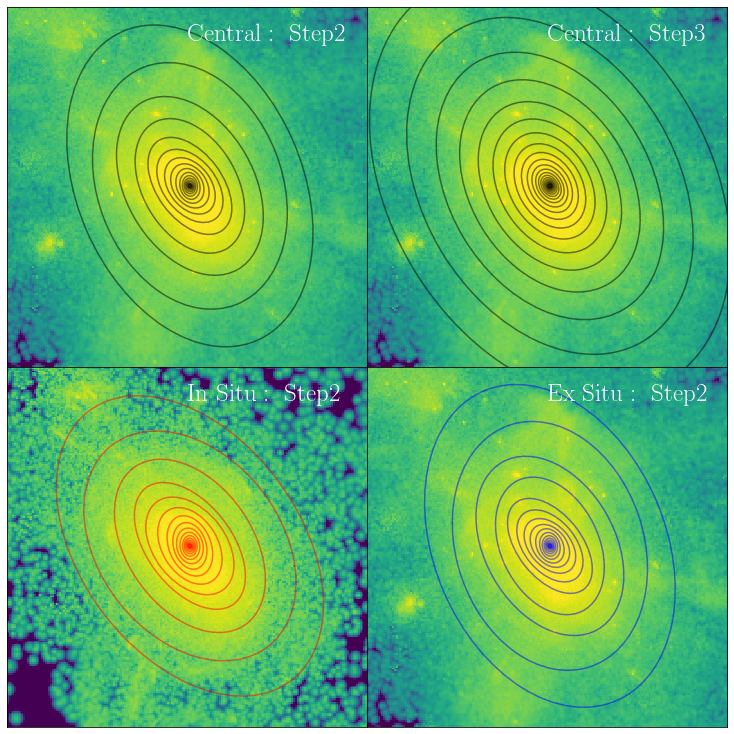

In [156]:
_ = tng_show_ellipse(ell_res, tng_maps_0[0])

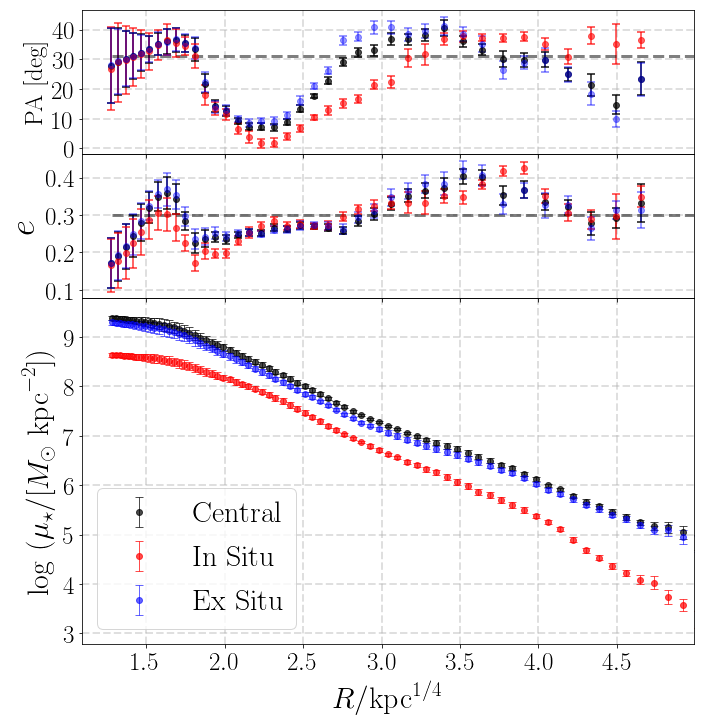

In [157]:
_ = tng_show_profile(ell_res)

#### Batch run with all TNG galaxies

In [160]:
tng_0_ell = [tng_get_1d_all(idx,
                            tng_0_cen_aper[idx], 
                            tng_0_ins_aper[idx], 
                            tng_0_exs_aper[idx], 
                            proj=0, tng_dir=tng_dir) 
             for idx in np.arange(n_galaxies)]

!!! DANGEROUS : Outer boundary is not safe !!!
!!! DANGEROUS : Outer boundary is not safe !!!


/Users/song/Dropbox/work/project/hs_hsc/py/galsbp/galSBP.py:795: RuntimeWarning: Mean of empty slice
  outRsma = np.nanmean(negRad)
/Users/song/Dropbox/work/project/hs_hsc/py/galsbp/galSBP.py:579: RuntimeWarning: divide by zero encountered in log10
  sbpOri = zp - 2.5 * np.log10(intensOri / (pixArea * exptime))
/Users/song/Dropbox/work/project/hs_hsc/py/galsbp/galSBP.py:580: RuntimeWarning: divide by zero encountered in log10
  sbpSub = zp - 2.5 * np.log10(intensSub / (pixArea * exptime))
/Users/song/Dropbox/work/project/hs_hsc/py/galsbp/galSBP.py:590: RuntimeWarning: divide by zero encountered in log10
  (pixArea * exptime))
/Users/song/Dropbox/work/project/hs_hsc/py/galsbp/galSBP.py:591: RuntimeWarning: invalid value encountered in subtract
  sbp_err = (sbpSub - sbp_low)
/Users/song/Dropbox/work/project/hs_hsc/py/galsbp/galSBP.py:1619: RuntimeWarning: divide by zero encountered in log10
  expTime))


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
###  ELLIPSE RUN FAILED IN ATTEMPT:  0
###  Error Information :  XXX Can not find the outBin: /Users/song/data/massive/simulation/illustris/illustris_map/tng_62_exs_0_ellip_4.bin!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
----------------------------------------------------------------------------------------------------
###  Maxsma  160.0 -->  144.0
----------------------------------------------------------------------------------------------------
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
###  ELLIPSE RUN FAILED IN ATTEMPT:  1
###  Error Information :  XXX Can not find the outBin: /Users/song/data/massive/simulation/illustris/illustris_map/tng_62_exs_0_ellip_4.bin!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
----

/Users/song/Dropbox/work/project/hs_hsc/py/hscUtils/hscUtils.py:833: RuntimeWarning: invalid value encountered in true_divide
  weights = np.array(weights).flatten() / float(sum(weights))


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
###  ELLIPSE RUN FAILED IN ATTEMPT:  0
###  Error Information :  zero-size array to reduction operation maximum which has no identity
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
----------------------------------------------------------------------------------------------------
###  Maxsma  100.0 -->   90.0
----------------------------------------------------------------------------------------------------
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
###  ELLIPSE RUN FAILED IN ATTEMPT:  1
###  Error Information :  zero-size array to reduction operation maximum which has no identity
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
------------------------------------------------------------------------------------------------

In [162]:
np.save(os.path.join(tng_dir, 'tng_0_ell.npy'), tng_0_ell)

In [163]:
tng_temp = np.load(os.path.join(tng_dir, 'tng_0_ell.npy'))

### Plot all the profiles

In [199]:
logms_cat = np.log10(cat_sh_mstar)
logmh_cat = np.log10(cat_sh_mdm)
logmb_cat = np.log10(cat_sh_mbh)
logmb_cat[~np.isfinite(logmb_cat)] = np.nan

logms_color = (logms_cat - np.min(logms_cat)) / (np.max(logms_cat) - np.min(logms_cat))
logmh_color = (logmh_cat - np.min(logmh_cat)) / (np.max(logmh_cat) - np.min(logmh_cat))
logmb_color = (logmb_cat - np.nanmin(logmb_cat)) / (np.nanmax(logmb_cat) - np.nanmin(logmb_cat))

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


#### Total stellar mass density profile  

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


Text(0,0.5,'$\\log\\ (\\mu_{\\star}/[M_{\\odot}\\ \\mathrm{kpc}^{-2}])$')

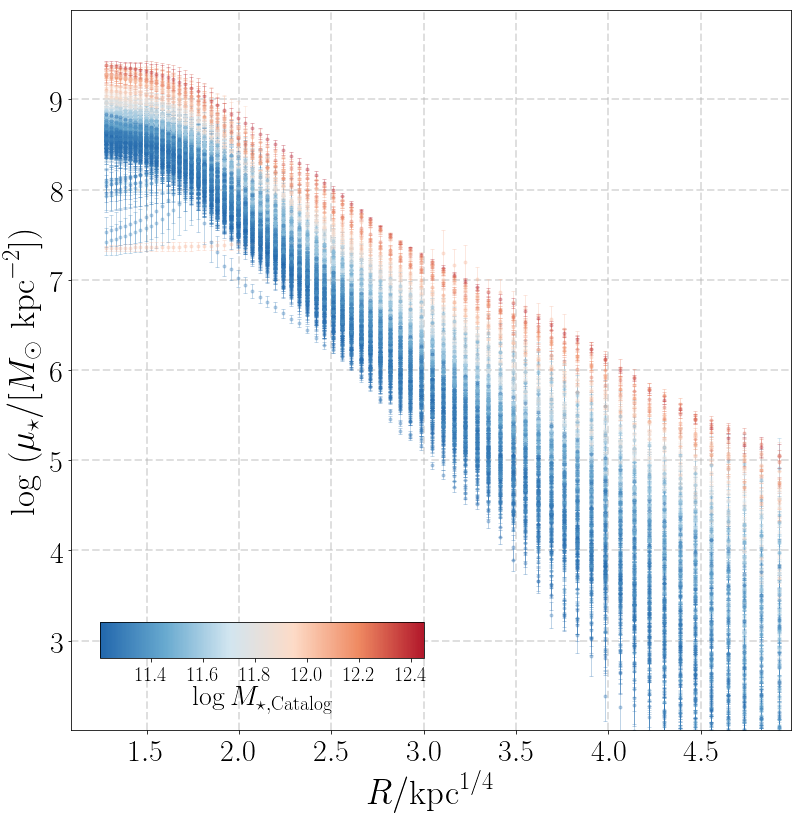

In [189]:
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0.0, right=1.0, 
                    bottom=0.0, top=1.0,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)

# 1-D profile
ax1.grid(linestyle='--', alpha=0.4, linewidth=2)

for ii, gal in enumerate(tng_0_ell):
    ell = gal['ell_cen_3']
    ax1.errorbar((ell['sma'] * pixel_scale) ** 0.25, 
                 np.log10(ell['intens'] / (pixel_scale ** 2)),
                 yerr=ell['sbp_err'], markersize=3,
                 color=B2R(logms_color[ii]), alpha=0.3, fmt='o', 
                 capsize=2, capthick=1, elinewidth=1,
                 label='__no_label__')
    
#ax1.legend(loc=3, fontsize=30)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)
    
cax = fig.add_axes([0.04, 0.10, 0.45, 0.05])
norm = mpl.colors.Normalize(vmin=np.min(logms_cat), 
                            vmax=np.max(logms_cat))
cb1 = mpl.colorbar.ColorbarBase(cax, cmap=B2R, norm=norm,
                                orientation='horizontal')
cb1.set_label(r'$\log M_{\star,\mathrm{Catalog}}$', fontsize=28)
    
ax1.set_xlim(1.09, 4.99)
ax1.set_ylim(2.01, 9.99)

ax1.set_xlabel(r'$R/\mathrm{kpc}^{1/4}$', fontsize=35)
ax1.set_ylabel(r'$\log\ (\mu_{\star}/[M_{\odot}\ \mathrm{kpc}^{-2}])$',
               fontsize=35)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


Text(0,0.5,'$\\log\\ (\\mu_{\\star}/[M_{\\odot}\\ \\mathrm{kpc}^{-2}])$')

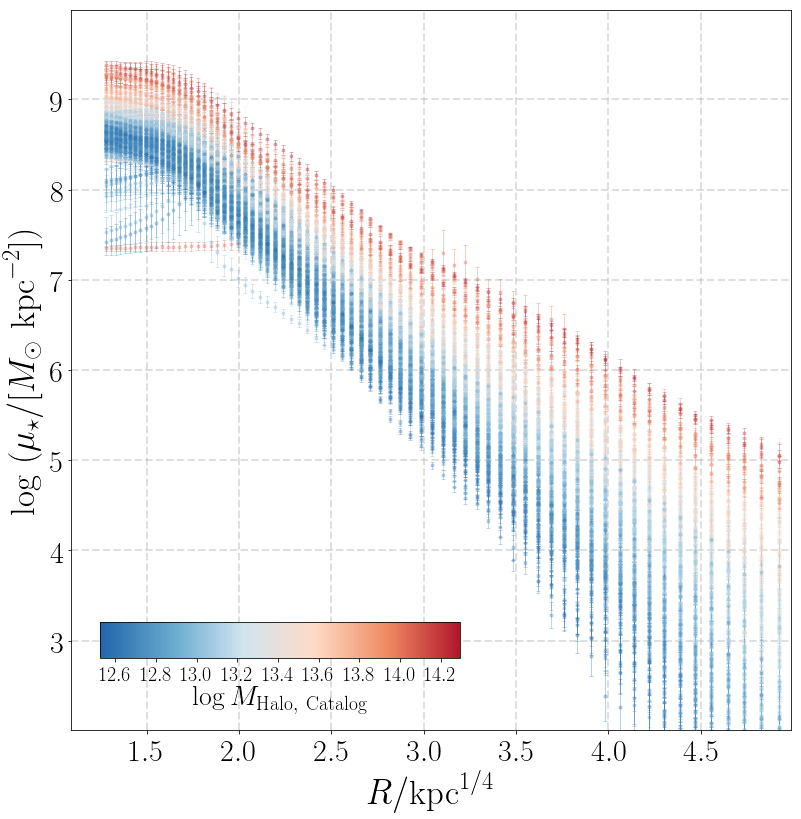

In [206]:
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0.0, right=1.0, 
                    bottom=0.0, top=1.0,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)

# 1-D profile
ax1.grid(linestyle='--', alpha=0.4, linewidth=2)

for ii, gal in enumerate(tng_0_ell):
    ell = gal['ell_cen_3']
    ax1.errorbar((ell['sma'] * pixel_scale) ** 0.25, 
                 np.log10(ell['intens'] / (pixel_scale ** 2)),
                 yerr=ell['sbp_err'], markersize=3,
                 color=B2R(logmh_color[ii]), alpha=0.3, fmt='o', 
                 capsize=2, capthick=1, elinewidth=1,
                 label='__no_label__')
    
#ax1.legend(loc=3, fontsize=30)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)
    
cax = fig.add_axes([0.04, 0.10, 0.50, 0.05])
norm = mpl.colors.Normalize(vmin=np.min(logmh_cat), 
                            vmax=np.max(logmh_cat))
cb1 = mpl.colorbar.ColorbarBase(cax, cmap=B2R, norm=norm,
                                orientation='horizontal')
cb1.set_label(r'$\log M_{\mathrm{Halo,\ Catalog}}$', fontsize=28)
    
ax1.set_xlim(1.09, 4.99)
ax1.set_ylim(2.01, 9.99)

ax1.set_xlabel(r'$R/\mathrm{kpc}^{1/4}$', fontsize=35)
ax1.set_ylabel(r'$\log\ (\mu_{\star}/[M_{\odot}\ \mathrm{kpc}^{-2}])$',
               fontsize=35)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


62
69


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log10


Text(0,0.5,'$\\log\\ (\\mu_{\\star}/[M_{\\odot}\\ \\mathrm{kpc}^{-2}])$')

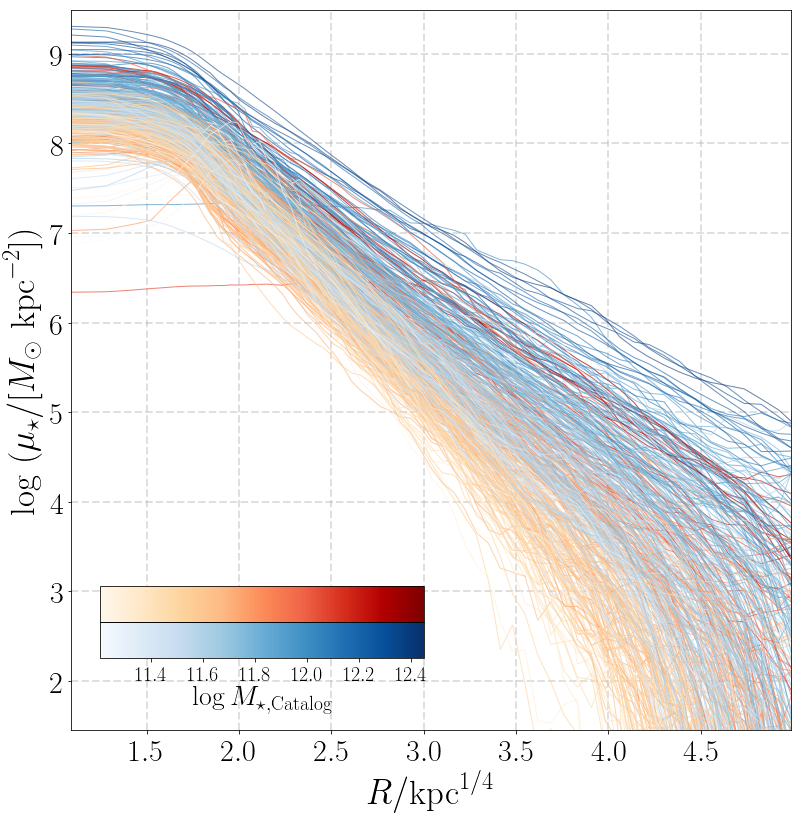

In [218]:
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0.0, right=1.0, 
                    bottom=0.0, top=1.0,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)

# 1-D profile
ax1.grid(linestyle='--', alpha=0.4, linewidth=2)

for ii, gal in enumerate(tng_0_ell):
    ell = gal['ell_ins_4']
    if ell is not None:
        ax1.plot((ell['sma'] * pixel_scale) ** 0.25, 
                 np.log10(ell['intens'] / (pixel_scale ** 2)),
                 color=ORG(logmb_color[ii]), alpha=0.7,
                 linewidth=1.0, linestyle='-', 
                 label='__no_label__')
    else:
        print('ins', ii)
    
    ell = gal['ell_exs_4']
    if ell is not None:
        ax1.plot((ell['sma'] * pixel_scale) ** 0.25, 
                 np.log10(ell['intens'] / (pixel_scale ** 2)),
                 color=BLU(logmb_color[ii]), alpha=0.6,
                 linewidth=1.0, linestyle='-', 
                 label='__no_label__')
    else:
        print('ii)
    
#ax1.legend(loc=3, fontsize=30)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)
    
cax1 = fig.add_axes([0.04, 0.10, 0.45, 0.05])
cax2 = fig.add_axes([0.04, 0.15, 0.45, 0.05])
norm = mpl.colors.Normalize(vmin=np.min(logms_cat), 
                            vmax=np.max(logms_cat))
cb1 = mpl.colorbar.ColorbarBase(cax1, cmap=BLU, norm=norm,
                                orientation='horizontal')
cb1.set_label(r'$\log M_{\star, \mathrm{Catalog}}$', fontsize=28)

cb2 = mpl.colorbar.ColorbarBase(cax2, cmap=ORG, norm=norm, ticks=[],
                                orientation='horizontal')
    
ax1.set_xlim(1.09, 4.99)
ax1.set_ylim(1.45, 9.49)

ax1.set_xlabel(r'$R/\mathrm{kpc}^{1/4}$', fontsize=35)
ax1.set_ylabel(r'$\log\ (\mu_{\star}/[M_{\odot}\ \mathrm{kpc}^{-2}])$',
               fontsize=35)

#### Plot the ellipticity profiles

Text(0,0.5,'$\\mathrm{Ellipticity}$')

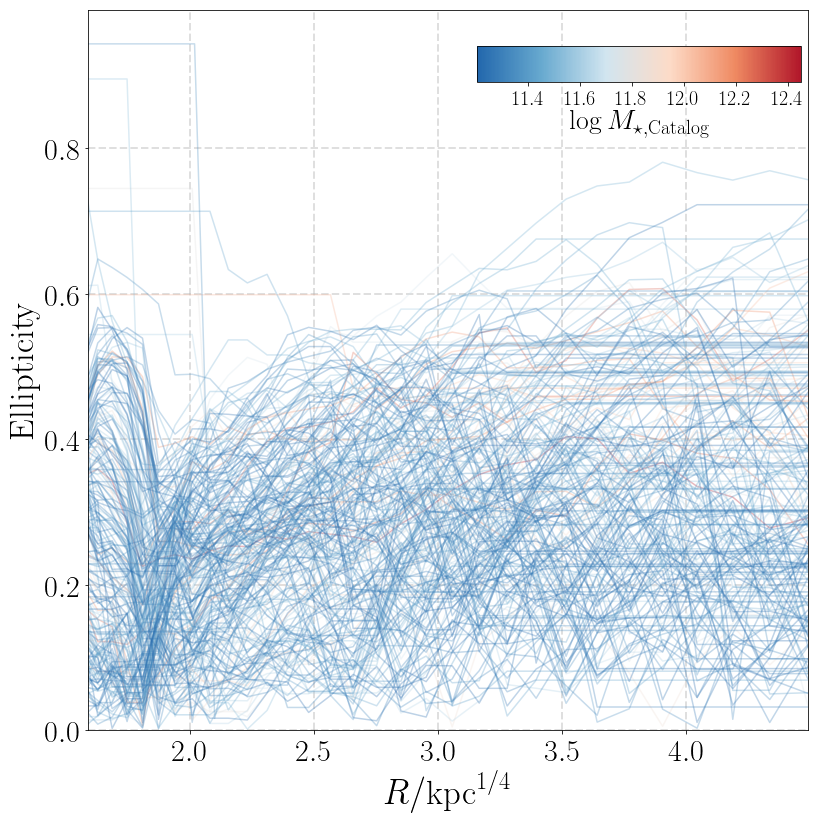

In [217]:
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0.0, right=1.0, 
                    bottom=0.0, top=1.0,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)

# 1-D profile
ax1.grid(linestyle='--', alpha=0.4, linewidth=2)

for ii, gal in enumerate(tng_0_ell):
    ell = gal['ell_cen_2']
    ax1.plot((ell['sma'] * pixel_scale) ** 0.25, 
             ell['ell'],
             color=B2R(logms_color[ii]), alpha=0.3,
             label='__no_label__')
    
#ax1.legend(loc=3, fontsize=30)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)
    
cax = fig.add_axes([0.54, 0.90, 0.45, 0.05])
norm = mpl.colors.Normalize(vmin=np.min(logms_cat), 
                            vmax=np.max(logms_cat))
cb1 = mpl.colorbar.ColorbarBase(cax, cmap=B2R, norm=norm,
                                orientation='horizontal')
cb1.set_label(r'$\log M_{\star,\mathrm{Catalog}}$', fontsize=28)
    
ax1.set_xlim(1.59, 4.49)
ax1.set_ylim(0.00, 0.99)

ax1.set_xlabel(r'$R/\mathrm{kpc}^{1/4}$', fontsize=35)
ax1.set_ylabel(r'$\mathrm{Ellipticity}$',
               fontsize=35)